This notebook examines how genre list length correlates with gender.

The model that looks to be statistically significant splits the data into two bins: length $\leq 5$ and length $\geq 6$. For each bin, calculate
$$\frac{\text{actual # of male artists in bin}}{\text{expected # of male artists in bin}}$$
where the expected number of male artists in a bin is ${\% \text{male in total sample} \cdot \text{total in bin}}$. For the first bin, with the number of genre labels $\leq 5$, the ratio is $1$ within expected error rates. However, for the second bin, male artists are over represented and female artists are under represented.


In [1]:
import numpy as np
import pandas as pd

seed = 23

import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline
#%matplotlib notebook

from sklearn.model_selection import KFold

import re

from functools import partial

import plotly.graph_objects as go

from nested_subsets import NestedSubsets

Import the cleaned data:

In [2]:
%store -r now

X_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_X_train_{}.csv'.format(now), index_col = ['artist'])
y_train = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/wiki-kaggle_y_train_{}.csv'.format(now), index_col = ['artist'])

data = y_train.join( [X_train], how = 'outer')

### Genre Labels

Each value of the genre column is a _string_ of comma separated genre labels. We want to convert it to a _list_ of strings.

In [3]:
"""This function takes in a string of the form
appearing in the genrelist of the dataframe.
It strips the square brackets and extra quotes and
returns a list of strings where each string is a genre label."""
def genrelist(string):
    string = string.strip("[").strip("]").replace("'","")
    L = [s for s in string.split(',')]
    L_new = []
    for x in L:
        L_new.append(x.replace(" ","_").lstrip("_").rstrip("_"))
    while (str("") in L_new):
        L_new.remove("")
    return L_new

Now we apply it to the whole column and put the lists in a new column:

In [4]:
data['genrelist']= data['genrelist'].apply(genrelist)

### Import the labels from the whole data set:

In [5]:
genrelist_df = pd.read_csv('/Users/Daniel/Code/Genre/data/genre_lists/data_ready_for_model/genre_list_{}.csv'.format(now), index_col = 'Unnamed: 0')

In [6]:
data_male = data[data.gender == 'male']
data_female = data[data.gender == 'female']

In [7]:
tot = data.shape[0]
mal = data_male.shape[0]
fem = data_female.shape[0]
print('{} total artists'.format(tot))
print('There are {} unique genre labels.'.format(genrelist_df.shape[0]))
print('{} female artists, or {:0.0f}%'.format(fem, 100*fem/(fem+mal)))
print('{} male artists, or {:0.0f}%'.format(mal, 100*mal/(fem+mal)))

12376 total artists
There are 1494 unique genre labels.
3847 female artists, or 31%
8529 male artists, or 69%


## Calculate ratios of actual to expected for male and female using two bins for list lengths: <6 and >5 

### This function creates a DF with the frequencies of the lengths of lists by gender for a df of the type of "data" above. It is used in the bin_cv_est function below.

In [8]:
def create_length_counts_by_gender(df):
    """df is """
    
    #length counts total
    dft = df.groupby(['genrelist_length']).count()
    dft.drop(['gender'], axis = 1, inplace = True)
    dft.columns = ['artist_count']
    
    # length counts by gender
    df = df.groupby(['genrelist_length','gender']).count()
    df.columns = ['artist_count']

    df.reset_index(inplace = True)
    df.set_index(['genrelist_length'], inplace = True)
    df = df.pivot(columns = 'gender')
    
    #flatten index and replace with single strings
    df.columns = df.columns.to_flat_index()
    df.columns = [name[1] for name in df.columns]
    #combine total count with gender counts
    dft.columns = ['total']
    df = dft.join(df, how = 'outer')
    
    df.fillna(value = {'female': 0}, inplace = True)
    
    return df

In [9]:
lcbg = create_length_counts_by_gender(data)

### The bin_est function estimates actual/expected ratios for male and female by genre list length by binning the data into < 6 and > 5 bins.

In [11]:
def bin_est(df):
    
    # create length counts by gender
    lcbg = create_length_counts_by_gender(df)

    # mark rows by their class (uses ordering; could be done with masking)
    lcbg['classify'] = '1-5'
    lcbg.iloc[6:,-1] = '>5'

    # calculate totals for each bin
    twobins = lcbg.groupby(['classify']).agg('sum')

    # calculated columns: expected and ratios 
    twobins['expected female'] = (.31*twobins['total']).astype('int64')
    twobins['expected male'] = (.69*twobins['total']).astype('int64')
    twobins['male_act_exp_ratio'] =twobins['male']/ twobins['expected male']
    twobins['female_act_exp_ratio'] =  twobins['female']/ twobins['expected female']

    # only keep needed columns
    twobins = twobins[['female_act_exp_ratio','male_act_exp_ratio']]

    return twobins

Calculate twobin biases for nested subsets over multiple runs (random selection of subsets). Store the results and calculate the mean and std for each size over the runs.

In [14]:
# set the number of runs
k = 10

# Set percentage or step_size; step_size overrides percentage
percentage = .1
step_size = None

# initialize a DataFrame to save biases calculated for each nested subsample
# call NestedSubsets to get the_number_of_subsets and step_size
subsets = NestedSubsets(data, step_size, percentage = percentage)
number_of_steps = subsets.get_number_of_steps()
step_size = subsets.get_step_size()

# create list of sizes of subsets to use as level in MultiIndex
sizes = [data.shape[0]-j*step_size for j in range(number_of_steps)]

# create empty DF with MultiIndex
indices = [sizes, ['1-5','>5']]
columns = [[f'run_{i}' for i in range(k)], ['female_act_exp_ratio','male_act_exp_ratio']]
biases = pd.DataFrame(index = pd.MultiIndex.from_product(indices), columns = pd.MultiIndex.from_product(columns), dtype = float)
biases.index.names = ['size','bin']
biases.columns.names = ['runs','gender']

# define slicer for accessing slices of multi-indexed DF
idx = pd.IndexSlice

for i in range(k): # perform k runs
    # create the subset generator
    subsets = NestedSubsets(data, step_size, percentage = percentage)
    # get the step_size from the subset generator
    step_size = subsets.get_step_size()
    
    # loop through subsets
    for subset in subsets:
        size = subset.shape[0]
        if size >= step_size: # excluding the remainder samples
            twobins = bin_est(subset) # calculate biases
            
            # set indices of twobins to match the slice of relevant biases 
            indices = [[size],['1-5', '>5']]
            columns = [[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]
            twobins.index = pd.MultiIndex.from_product(indices)
            twobins.columns = pd.MultiIndex.from_product(columns)
            
            # set values
            biases.loc[idx[[size],['1-5', '>5']],idx[[f'run_{i}'],['female_act_exp_ratio','male_act_exp_ratio']]] = twobins

biases.sort_index(ascending = False)
means = biases.groupby(['gender'], axis = 1).mean()
means.columns = pd.MultiIndex.from_product([['means'],['fem mean','mal mean']])
stds = biases.groupby(['gender'], axis = 1).std()
stds.columns = pd.MultiIndex.from_product([['stds'],['fem std','mal std']])
biases = biases.join([means, stds])

Show a plot of the biases over multiple runs

In [16]:
biases.head()

runs                     run_0                                   run_1  \
gender    female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
size  bin                                                                
12376 1-5             1.016371           0.992767             1.016371   
      >5              0.550459           1.204918             0.550459   
11139 1-5             1.013103           0.994248             1.006555   
      >5              0.531915           1.215311             0.562500   
9902  1-5             1.015400           0.993232             1.000000   

runs                                        run_2                     \
gender    male_act_exp_ratio female_act_exp_ratio male_act_exp_ratio   
size  bin                                                              
12376 1-5           0.992767             1.016371           0.992767   
      >5            1.204918             0.550459           1.204918   
11139 1-5           0.997189             1.014021           0.993836   
      >5            1.200935             0.550000           1.207207   
9902  1-5           1.000150             1.002685           0.998945   

runs                     run_3                                   run_4  \
gender    female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
size  bin                                                                
12376 1-5             1.016371           0.992767             1.016371   
      >5              0.550459           1.204918             0.550459   
11139 1-5             1.008644           0.996251             1.017894   
      >5              0.556701           1.202765             0.555556   
9902  1-5             1.019779           0.991264             1.016767   

runs                          ...                run_7                     \
gender    male_act_exp_ratio  ... female_act_exp_ratio male_act_exp_ratio   
size  bin                     ...                                           
12376 1-5           0.992767  ...             1.016371           0.992767   
      >5            1.204918  ...             0.550459           1.204918   
11139 1-5           0.992096  ...             1.025656           0.988610   
      >5            1.204545  ...             0.570000           1.198198   
9902  1-5           0.992619  ...             1.022819           0.989897   

runs                     run_8                                   run_9  \
gender    female_act_exp_ratio male_act_exp_ratio female_act_exp_ratio   
size  bin                                                                
12376 1-5             1.016371           0.992767             1.016371   
      >5              0.550459           1.204918             0.550459   
11139 1-5             1.016696           0.992633             1.014601   
      >5              0.510204           1.223744             0.546392   
9902  1-5             1.020127           0.991109             1.020134   

runs                             means                stds            
gender    male_act_exp_ratio  fem mean  mal mean   fem std   mal std  
size  bin                                                             
12376 1-5           0.992767  1.016371  0.992767  0.000000  0.000000  
      >5            1.204918  0.550459  1.204918  0.000000  0.000000  
11139 1-5           0.993573  1.014103  0.993799  0.005383  0.002418  
      >5            1.209302  0.548429  1.207284  0.016774  0.007433  
9902  1-5           0.991105  1.014053  0.993837  0.007725  0.003471  

[5 rows x 24 columns]

In [54]:
# each row is a run, from small subset to large
fem_small_runs = np.stack([np.flip(df.loc[ idx[:,'1-5'], idx[[f'run_{i}'],['female_act_exp_ratio']] ].values.flatten()) for i in range(k)])
mal_small_runs = np.stack([np.flip(df.loc[ idx[:,'1-5'], idx[[f'run_{i}'],['male_act_exp_ratio']] ].values.flatten()) for i in range(k)])
fem_large_runs = np.stack([np.flip(df.loc[ idx[:,'>5'], idx[[f'run_{i}'],['female_act_exp_ratio']] ].values.flatten()) for i in range(k)])
mal_large_runs = np.stack([np.flip(df.loc[ idx[:,'>5'], idx[[f'run_{i}'],['male_act_exp_ratio']] ].values.flatten()) for i in range(k)])

In [86]:
[*5*'']

[' ', ' ', ' ', ' ', ' ']

In [96]:
fem_small_labels = ['female']+[None for i in range(k-1)]
fem_small_labels

['female', None, None, None, None, None, None, None, None, None]

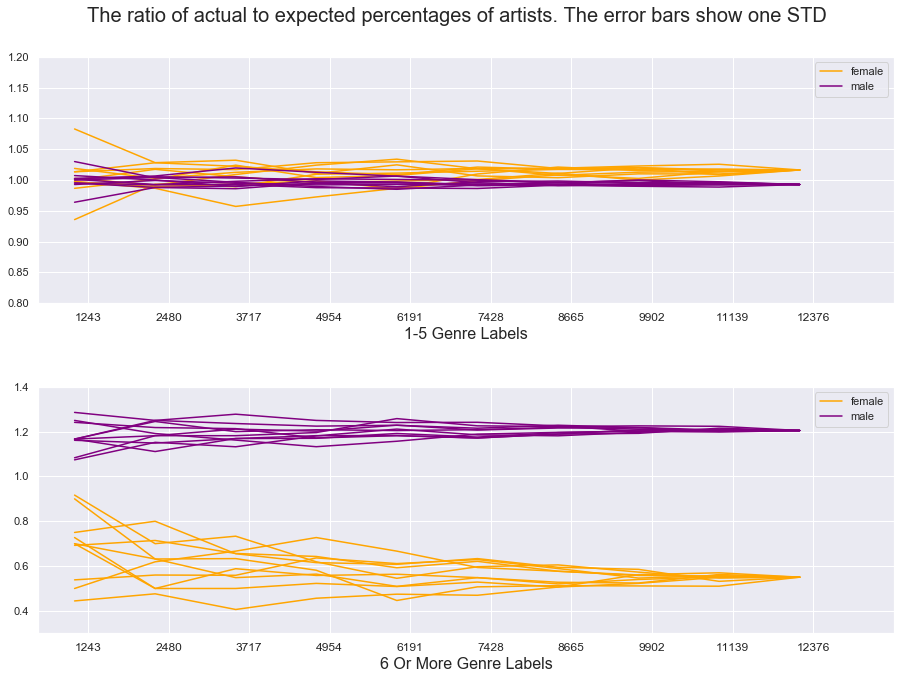

In [137]:
idx = pd.IndexSlice
df = biases
# extract lists of values for the means of each category
# flip arrays so that subset size increases left to right



# indices for bars
number_of_bars = len(df_fem_small)
ind_fem = np.arange(0,3*number_of_bars,3)
ind_mal = np.arange(1,3*number_of_bars+1,3)
xlabel_pos = np.arange(0,3*number_of_bars+1,3)+.5

# set xticklabels; flip so order is small to large, as above
xticklabels = np.flip(df.loc[idx[:,'1-5'],:].index.get_level_values(0).values)

fig, axs = plt.subplots(2,1, figsize = (14,10))
fig.suptitle('The ratio of actual to expected percentages of artists. The error bars show one STD', fontsize = 20)
fig.tight_layout(pad = 6.0)
for i in range(k):
    axs[0].plot(ind_fem,fem_small_runs[i], color = 'orange', label = f'fem_small_runs_{i}' )

for i in range(k):
    axs[0].plot(ind_fem,mal_small_runs[i], color = 'purple', label = f'mal_small_runs_{i}')
    
for i in range(k):
    axs[1].plot(ind_fem,fem_large_runs[i], color = 'orange', label = f'fem_large_runs_{i}')

for i in range(k):
    axs[1].plot(ind_fem,mal_large_runs[i], color = 'purple', label = f'mal_large_runs_{i}')

# axs[0].bar(ind_mal,df_mal_small, color = 'purple', yerr = eb_mal_small, capsize = 4, label = 'male')


# y range

axs[0].set_ylim(bottom = .8, top = 1.2)
axs[1].set_ylim(bottom = .3,top = 1.4)

# styles
axs[0].set_xticks(xlabel_pos)
axs[0].set_xticklabels(xticklabels, fontsize = 12, rotation = 0)
axs[1].set_xticks(xlabel_pos)
axs[1].set_xticklabels(xticklabels, fontsize = 12, rotation = 0)
axs[0].set_xlabel('1-5 genre labels'.title(), fontsize = 16)
axs[1].set_xlabel('6 or more genre labels'.title(), fontsize = 16)

handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles = [handles[0], handles[k]], labels = ['female', 'male'])
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles = [handles[0], handles[k]], labels = ['female', 'male'])

In [138]:
fig.savefig('/Users/Daniel/Code/Genre/visualizations/twobin_paths.png')

Plot the mean and std over the runs for each subset set 

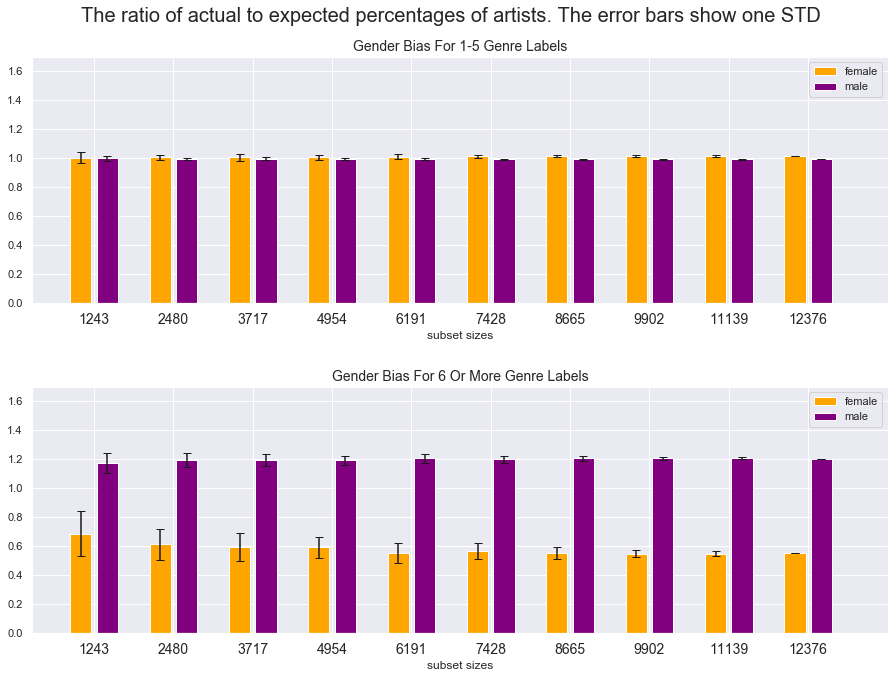

In [149]:
idx = pd.IndexSlice
df = biases
# extract lists of values for the means of each category
# flip arrays so that subset size increases left to right
df_fem_small = np.flip(df.loc[ idx[:,'1-5'], idx[['means'],['fem mean']] ].values.flatten())
df_fem_large = np.flip(df.loc[ idx[:,'>5'], idx[['means'],['fem mean']] ].values.flatten())
df_mal_small = np.flip(df.loc[ idx[:,'1-5'], idx[['means'],['mal mean']] ].values.flatten())
df_mal_large = np.flip(df.loc[ idx[:,'>5'], idx[['means'],['mal mean']] ].values.flatten())

# extract the stds
eb_fem_small = np.flip(df.loc[ idx[:,'1-5'], idx[['stds'],['fem std']] ].values.flatten())
eb_fem_large = np.flip(df.loc[ idx[:,'>5'], idx[['stds'],['fem std']] ].values.flatten())
eb_mal_small = np.flip(df.loc[ idx[:,'1-5'], idx[['stds'],['mal std']] ].values.flatten())
eb_mal_large = np.flip(df.loc[ idx[:,'>5'], idx[['stds'],['mal std']] ].values.flatten())

# indices for bars
number_of_bars = len(df_fem_small)
ind_fem = np.arange(0,3*number_of_bars,3)
ind_mal = np.arange(1,3*number_of_bars+1,3)
xlabel_pos = np.arange(0,3*number_of_bars+1,3)+.5

# set xticklabels; flip so order is small to large, as above
xticklabels = np.flip(df.loc[idx[:,'1-5'],:].index.get_level_values(0).values)

fig, axs = plt.subplots(2,1, sharey = True, figsize = (14,10))
fig.tight_layout(pad = 6.0)
fig.suptitle('The ratio of actual to expected percentages of artists. The error bars show one STD', fontsize = 20)
axs[0].bar(ind_fem,df_fem_small, color = 'orange', yerr = eb_fem_small, capsize = 4, label = 'female')
axs[0].bar(ind_mal,df_mal_small, color = 'purple', yerr = eb_mal_small, capsize = 4, label = 'male')
axs[1].bar(ind_fem,df_fem_large, color = 'orange', yerr = eb_fem_large, capsize = 4, label = 'female')
axs[1].bar(ind_mal,df_mal_large, color = 'purple', yerr = eb_mal_large, capsize = 4, label = 'male')

# y range
axs[0].set_ylim(0,1.7)
axs[1].set_ylim(0,1.7)

# styles
axs[0].set_title('Gender Bias for 1-5 genre labels'.title(), fontsize = 14)
axs[1].set_title('Gender Bias for 6 or more genre labels'.title(), fontsize = 14)

axs[0].set_xticks(xlabel_pos)
axs[0].set_xticklabels(xticklabels, fontsize = 14, rotation = 0)
axs[1].set_xticks(xlabel_pos)
axs[1].set_xticklabels(xticklabels, fontsize = 14, rotation = 0)
axs[0].set_xlabel('subset sizes', fontsize = 12)
axs[1].set_xlabel('subset sizes', fontsize = 12)
axs[0].legend()
axs[1].legend()

In [140]:
fig.savefig('/Users/Daniel/Code/Genre/visualizations/twobin_means.png')